# Bandit Problem

In [1]:
# imports
from bandits import Bandit
import random
# Include your imports here, if any are used. import numpy as np 
import matplotlib.pyplot as plt

A bandit is one option (or “arm”) you can choose, where the reward you get is uncertain and must be learned by trying it out.
In multi-armed bandits, you repeatedly pick among several such uncertain options to find which one pays best.

A list of ten bandit objects initialized in the list...

In [2]:
bandits = [Bandit(random.random()*4-2) for _ in range(10)]

To generate reward from that bandit, use the pullLever() command

In [3]:
bandits[0].pullLever()

0.04364432528747145

## Greedy algorithm Implementation

In [4]:
def run_greedy():
    # TODO: Implement the greedy algorithm here
    # Return the reward from the bandits in a list
 avg_arr = np.zeros(10)
 count = np.zeros(10)
rewards = []
 for t in range(1000):
    maxval = np.max(avg_arr)
    i=np.argmax(avg_arr)
    reward = bandits[i].pullLever()
    rewards.append(reward)
    count[i] += 1
    avg_arr[i] += (1 / count[i]) * (reward - avg_arr[i])
return rewards
    
    pass

Plot the cumulative average of rewards as the number of iterations increases. and display that image below.

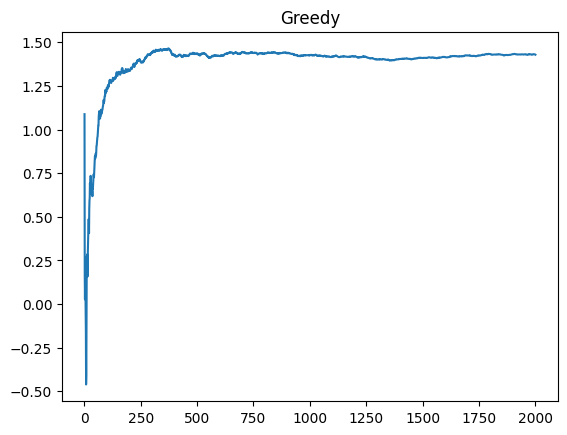

In [100]:
 def plot_cumulative_average(rewards_list, labels):
plt.figure(figsize=(10, 6))
for rewards, label in zip(rewards_list, labels):
cum_avg = np.cumsum(rewards) / np.arange(1, len(rewards)+1)
     plt.plot(cum_avg, label=label)
 plt.xlabel('Iterations')
 plt.ylabel('Cumulative Average Reward')
 plt.legend()
 plt.title('Cumulative Average Reward Over Time')
 plt.show()


## $\epsilon$-greedy Algorithm

In [5]:
def run_epsilon_greedy(epsilon):
    # TODO: Implement the epsilon greedy algorithm here
    # Return the reward from the bandits in a list

    pass

Plot the cumulative average of rewards as the number of iterations increases but for various values of $\epsilon$.

## Finding the optimal $\epsilon$

Run the $\epsilon$-greedy algorithm for 1000 iterations and find the optimal $\epsilon$ value by plotting the cumulative average of rewards for various values of $\epsilon$

## Optimistic Initial Values

In [6]:
def run_optimistic_greedy():
    # TODO: Implement the optimistic greedy algorithm here

    # Return the reward from the bandits in a list
    pass

Plot the cumulative average of rewards as the number of iterations increases for an optimistic greedy of $Q_1 = 10$ and a non-optimistic $\epsilon = 0.1$ and try to compare which is better.

## Upper Confidence Bound (UCB)

In [7]:
def run_ucb(c):
    # TODO: Implement the UCB algorithm here
    # Return the reward from the bandits in a list
    pass